# **AIML Online Capstone - Pneumonia Detection Challenge**
    
### Batch : AIML JULY 21 B GROUP 2 
    
### Group Members: 
1.   Manish Achuth
2.   Nikhil Prabhudesai
3.   Priya Sinha
4.   Rachit Goel
5.   Radha Sudha



# **Initial Setup**

In [ ]:
# setting for autosave of the notebook after every 60 seconds
%autosave 60

Autosaving every 60 seconds


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set google drive path
%cd "/content/drive/MyDrive/AIML2021/Capstone"

/content/drive/MyDrive/AIML2021/Capstone


In [ ]:
# install pydicom for reading dcm files
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.2 MB/s 


In [ ]:
# import all relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as dcm
from collections import Counter
from tqdm import tqdm
import matplotlib.patches as patches
import cv2
import os
from os import listdir
from os.path import isfile, join
import sys
import glob
import csv
import random
import tensorflow as tf
from tensorflow import keras
import random
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize
from imgaug import augmenters as iaa

# import relevant libraries for model building
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

tf.config.run_functions_eagerly(True)

# **Exploratory Data Analysis & Pre-processing**

## Train Label Data:

In [ ]:
# import the training labels data set
train_labels = pd.read_csv("stage_2_train_labels.csv")
train_labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

As we can see, each row in the CSV file contains a patientId, a target (either 0 or 1 for absence or presence of pneumonia, respectively) and the corresponding bounding box defined by the upper-left hand corner (x, y) coordinate and its corresponding width and height.



Some information about the data field present in the 'stage_2_train_labels.csv' are:

* **patientId** - A unique id assigned to a patient
* **x** - The upper-left x coordinate of the bounding box
* **y** - The upper-left y coordinate of the bounding box
* **width** - The width of the bounding box
* **height** - The height of the bounding box
* **Target** - The binary Target indicating whether this sample has evidence of pneumonia or not.



In [ ]:
train_labels.shape

(30227, 6)

There are 30277 records in the train labels data file.



In [ ]:
# check the Target column distribution
train_labels['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

The 30277 records are split with 20672 records having Target = 0 and 9555 records having Target = 1

In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


We can see that there are 9555 non-null values for x, y, width and height. This is expected as only patients with pneumonia (Target = 1) will have the bounding box cordinates available.

In [ ]:
# check for percentage of missing values for each attribute
print(round(train_labels.isna().sum()/train_labels.shape[0],3)*100)

patientId     0.0
x            68.4
y            68.4
width        68.4
height       68.4
Target        0.0
dtype: float64


It turns out that about 68.4% of the values in columns x, y, width and height are nulls i.e. Target = 0. That means about 31.6% of the values are non null i.e. Target = 1.

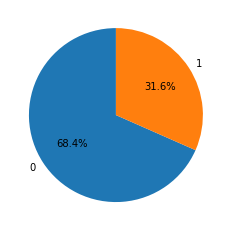

In [ ]:
# create a pie chart to show the distribution of Target column
prop = dict(Counter(train_labels['Target']))
plt.pie(prop.values(), labels=prop.keys(), autopct='%1.1f%%',startangle=90)
plt.show()

Confirming the above observation through a pie chart - we can see the distribution of Target = 0 and 1 to be 68.4% and 31.6% respectively.

In [ ]:
# check no. of unique patients present in the data
train_labels['patientId'].nunique()

26684

The number of unique patien Ids in the data is 26684. This means that 26684 patients amounts to data with 30277 rows. This can be explained by the fact that some of the patients will have multiple bounding box data present.

In [ ]:
# check no. of patients with different no. of bounding boxes
b_boxes_per_patient_id = train_labels.groupby('patientId').size().to_frame('number_of_boxes')
patient_ids_per_b_box_group = b_boxes_per_patient_id.groupby('number_of_boxes').size().to_frame('number_of_patients')
patient_ids_per_b_box_group

number_of_patients
number_of_boxes                    
1                             23286
2                              3266
3                               119
4                                13

We saw that there are 26684 unique patient ids in the data. Out of these, there are 23286 patient ids with 1 bounding box, 3266 patient ids with 2 bounding boxes, 119 patient ids with 3 bounding boxes and 13 patient ids with 4 bounding boxes available.

## Class Info Data:

In [ ]:
# import the class info data set
class_labels = pd.read_csv('stage_2_detailed_class_info.csv')
class_labels.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

Some information about the data field present in the 'stage_2_detailed_class_info.csv' are:

* **patientId** - A unique id assigned to a patient
* **class** - The current state of the patient's lung: 'No Lung Opacity / Not Normal', 'Normal' and 'Lung Opacity'.



In [ ]:
class_labels.shape

(30227, 2)

There are 30277 records in the class info data file.

In [ ]:
# check the Class column distribution
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

The 30277 records are split with 11821 records having Class = No Lung Opacity / Not Normal, 9555 records having Class = Normal and 8851 records having Class = Normal.

In [ ]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


There are no null values present in the data.

In [ ]:
# check no. of unique patients present in the data
class_labels['patientId'].nunique()

26684

The number of unique patien Ids in the data is 26684. This is same as the number of unique patient ids in the train label data.

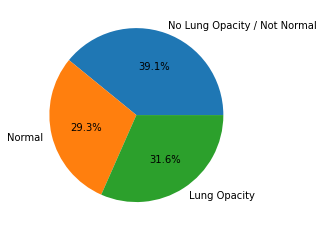

In [ ]:
# create a pie chart to show the distribution of Class column
prop = dict(Counter(class_labels['class']))
plt.pie(prop.values(), labels=prop.keys(), autopct='%1.1f%%')
plt.show()

The distribution of classes in the data are as follows:
* No Lung Opacity / Not Normal : 39.1%
* Normal : 29.3%
* Lung Opacity : 31.6%

In [ ]:
# Check to see if each patientId has only one type of class or not
class_labels.groupby(['patientId'])['class'].nunique().max()

1

This confirms that each patient id has only one corresponding class associated with it.

## Combined Data from Train Labels and Class Info Datasets:

In [ ]:
# concatenate the train_labels and class_labels dataset
train_data = pd.concat([train_labels, class_labels['class']], axis = 1)
train_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
train_data.shape

(30227, 7)

There are 30277 records in the combined dataset.

In [ ]:
# check the class distribution by Target
train_data.groupby('Target')['class'].value_counts()

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                     9555
Name: class, dtype: int64

We can view the data as follows:
* The total records in the dataset are 30277
* Out of these 30277 we have:
  * 20672 records with Target = 0. Out of these 20672 records we have:
    * 11821 records with class = No Lung Opacity / Not Normal
    * 8851 records with class = Normal
  * 9555 records with Target = 1.
    * All the 9555 records have class = Lung Opacity



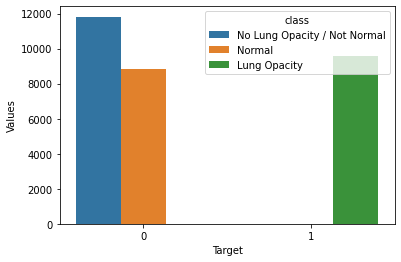

In [ ]:
# create a bar chart to confirm the above observation
target_class_combined_df = pd.DataFrame(data = {'Values': train_data.groupby('Target')['class'].value_counts().values}, 
                                        index = train_data.groupby('Target')['class'].value_counts().index).reset_index()
sns.barplot(x = 'Target', y = 'Values', hue = 'class', data = target_class_combined_df)

We can see that the Target = 1 data is only associated with Class = Lung Opacity and Target - 0 data is associatione with both Class = Normal and Class = No Lung Opacity / Not Normal.

We can now examine the bounding box data to see its distribution. For that we need data with Target = 1 because the bounding box data will only be available if the patient has pneumonia.

In [ ]:
# separate out the training data with target = 1
train_target_1 = train_data[train_data['Target']==1]

In [ ]:
train_target_1.shape

(9555, 7)

In [ ]:
train_target_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  9555 non-null   object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     9555 non-null   int64  
 6   class      9555 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 597.2+ KB


We now have all the 9555 records that have bounding box data available in it.

In order to find the center of the bounding box, we can use the following logic:
* x1 = x
* x2 = x + w
* y1 = y
* y2 = y + h
* x cordinate of center of bounding box = x1 + w/2
* y cordinate of center of bounding box = y1 + h/2

In [ ]:
# add center cordinates into the dataframe
train_target_1['center_x'] = train_target_1['x'] + train_target_1['width']/2
train_target_1['center_y'] = train_target_1['y'] + train_target_1['height']/2

In [ ]:
# check the new dataframe
train_target_1.head()

patientId      x      y  width  height  Target  \
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1   

           class  center_x  center_y  
4   Lung Opacity     370.5     341.5  
5   Lung Opacity     690.0     378.5  
8   Lung Opacity     403.0     629.0  
9   Lung Opacity     776.0     643.5  
14  Lung Opacity     335.0     389.5

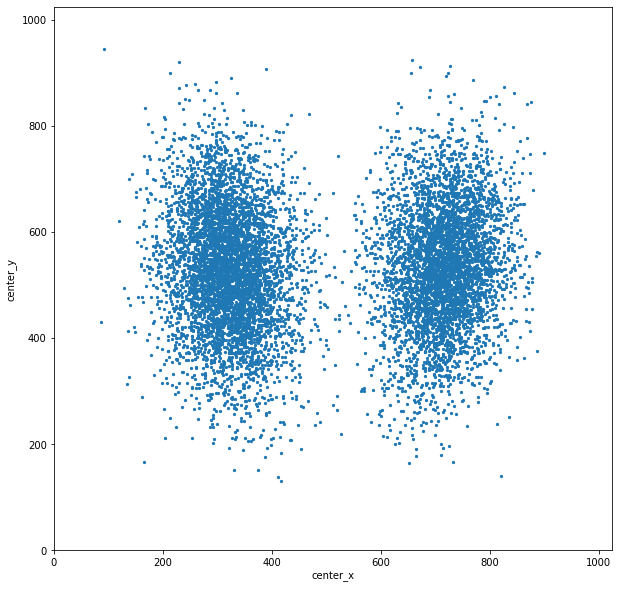

In [ ]:
# generate a scatter plot of the center of bounding boxes for image size 1024 X 1024
fig, ax = plt.subplots(1, 1, figsize = (10, 10));
train_target_1.plot.scatter(ax = ax, x='center_x', y='center_y',xlim = (0, 1024), ylim = (0, 1024),marker = '.');

We can see that the center of the bounding boxes seem to be spread across the lungs. While most of them are concentrated at the center, some of them are towards the edges as well.

## EDA Report using DataPrep Library:

In [ ]:
!pip install dataprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


DataPrep Report
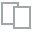
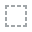
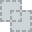
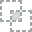
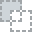
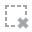
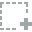
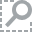
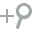
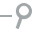
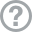
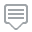
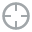
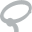
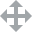
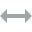
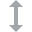
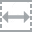
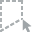
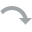
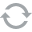
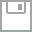
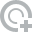
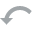
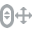
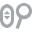
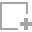
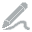
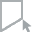
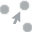
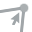
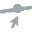

In [ ]:
# create EDA report of the combined data
from dataprep.eda import create_report
create_report(train_data)

## Using Image Metadata:

In [ ]:
# check metadata of one of the sample images
sample_patient_image = train_data['patientId'][0]
sample_dcm_file_path = 'stage_2_train_images/'+'{}.dcm'.format(sample_patient_image)
sample_img_data = dcm.read_file(sample_dcm_file_path)
sample_img_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

From the above data, we can see that patient's sex, patient's age and view position seems important for our data analysis.

In [ ]:
# patientId = train_data['patientId'].drop_duplicates().values
# patient_info = pd.DataFrame()
# for p in tqdm(patientId):
#     ds = dcm.dcmread('stage_2_train_images/' + p + '.dcm',stop_before_pixels=True)
#     tmp_info = pd.DataFrame({
#         'patientId': [ds.PatientID],
#         'age': [ds.PatientAge],
#         'gender': [ds.PatientSex],
#         'view_position': [ds.ViewPosition]
#     })
#     patient_info = patient_info.append(tmp_info)



> **Now that we have extracted the metadata information for all the patients in the training data, we will comment out the above code so that it is not part of the entire notebook execution.**

> **Also, we will save the dataframe with the metadata information (patient_info) into a csv and use it in future so that we do not have to extract the metadata information everytime. Metadata extraction of 26k+ patients from their dcm files is a time consuming process (taking over 1.5 hours on colab) and we would not want to do it again and again during our notebook execution.**








In [ ]:
# # save the metadata information into a csv file for future usage. Commenting to avoid overwriting the csv
# patient_info.to_csv('patient_image_metadata.csv', index=False)

In [ ]:
# import the image metadata labels data set
img_metadata = pd.read_csv("patient_image_metadata.csv")
img_metadata.head()

patientId  age gender view_position
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6   51      F            PA
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd   48      F            PA
2  00322d4d-1c29-4943-afc9-b6754be640eb   19      M            AP
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5   28      M            PA
4  00436515-870c-4b36-a041-de91049b9ab4   32      F            AP

In [ ]:
img_metadata.shape

(26684, 4)

The metadata consists of data for all 26684 unique patients.

In [ ]:
# check column information
img_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patientId      26684 non-null  object
 1   age            26684 non-null  int64 
 2   gender         26684 non-null  object
 3   view_position  26684 non-null  object
dtypes: int64(1), object(3)
memory usage: 834.0+ KB


In [ ]:
# merge the csv data with the image metadata to form the final dataframe
final_data = pd.merge(train_data.assign(patientId=train_data.patientId.astype(str)), 
         img_metadata.assign(patientId=img_metadata.patientId.astype(str)), 
         how='left', on='patientId')

In [ ]:
final_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  age gender view_position  
0  No Lung Opacity / Not Normal   51      F            PA  
1  No Lung Opacity / Not Normal   48      F            PA  
2  No Lung Opacity / Not Normal   19      M            AP  
3                        Normal   28      M            PA  
4                  Lung Opacity   32      F            AP

In [ ]:
final_data.shape

(30227, 10)

In [ ]:
final_data.describe()

x            y        width       height        Target  \
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000   
mean    394.047724   366.839560   218.471376   329.269702      0.316108   
std     204.574172   148.940488    59.289475   157.750755      0.464963   
min       2.000000     2.000000    40.000000    45.000000      0.000000   
25%     207.000000   249.000000   177.000000   203.000000      0.000000   
50%     324.000000   365.000000   217.000000   298.000000      0.000000   
75%     594.000000   478.500000   259.000000   438.000000      1.000000   
max     835.000000   881.000000   528.000000   942.000000      1.000000   

                age  
count  30227.000000  
mean      46.797764  
std       16.892940  
min        1.000000  
25%       34.000000  
50%       49.000000  
75%       59.000000  
max      155.000000

We see some unusual information from the above analysis. The minimum age is 1 however the maximum age is 155 which seems erroneous.

In [ ]:
# check gender distribution
final_data.gender.value_counts()

M    17216
F    13011
Name: gender, dtype: int64

Out of the 30277 records we can see that 17216 records are for Males and 13011 records are for females. These number are not indicative of the number of male and female patients as we had seen earlier that same patient may have more than one rows due to multiple bounding box data.

In [ ]:
# check the gender distribution for unique patient Ids
final_data.drop_duplicates(subset="patientId",inplace=False).gender.value_counts()

M    15166
F    11518
Name: gender, dtype: int64

Now we see the number of male patients as 15166 and number of female patients as 11518. These total to 26684 which is same as the number of unique patients in the data.

In [ ]:
# check the view position distribution for unique patient Ids
final_data.drop_duplicates(subset="patientId",inplace=False).view_position.value_counts()

PA    14511
AP    12173
Name: view_position, dtype: int64

We can see that out of 26684 patients, 14511 have view position as Posterior/Anterior (PA) while 12173 have view position as Anterior/Posterior (AP).


* **Posterior/Anterior (PA):** Here the chest radiograph is acquired by passing the X-Ray beam from the patient's posterior (back) part of the chest to the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film. In this image, the hear is on the right side of the image as one looks at it. These are of higher quality and assess the heart size more accurately
* **Anterior/Posterior (AP):** At times it is not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. In these images the size of Heart is exaggerated.

(Source: various links on Google)

In [ ]:
# add center cordinates into the dataframe
final_data['center_x'] = final_data['x'] + final_data['width']/2
final_data['center_y'] = final_data['y'] + final_data['height']/2

In [ ]:
final_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  age gender view_position  center_x  center_y  
0  No Lung Opacity / Not Normal   51      F            PA       NaN       NaN  
1  No Lung Opacity / Not Normal   48      F            PA       NaN       NaN  
2  No Lung Opacity / Not Normal   19      M            AP       NaN       NaN  
3                        Normal   28      M            PA       NaN       NaN  
4                  Lung Opacity   32      F            AP     370.5     341.5

In [ ]:
final_data.shape

(30227, 12)

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patientId      30227 non-null  object 
 1   x              9555 non-null   float64
 2   y              9555 non-null   float64
 3   width          9555 non-null   float64
 4   height         9555 non-null   float64
 5   Target         30227 non-null  int64  
 6   class          30227 non-null  object 
 7   age            30227 non-null  int64  
 8   gender         30227 non-null  object 
 9   view_position  30227 non-null  object 
 10  center_x       9555 non-null   float64
 11  center_y       9555 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 3.0+ MB


In [ ]:
# separate out data where Target = 1 i.e. patients with pnemonia.
bboxes_data = final_data[final_data['Target'] == 1]

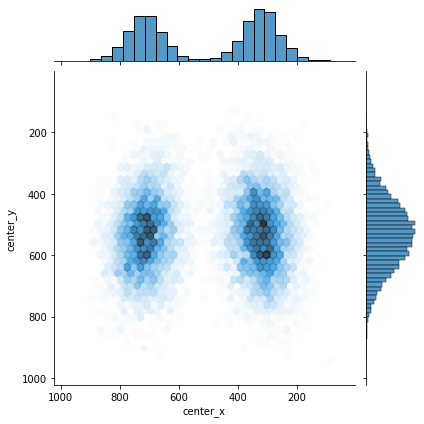

In [ ]:
# create a jointplot for all patients
sns.jointplot(x = 'center_x', y = 'center_y', data = bboxes_data, kind = 'hex', alpha = 0.8,xlim = 1024, ylim = 1024);

We have seen the similar chart as a scatter plot earlier. However, this hex chart is giving us a clearer idea of distribution of centers of bounding boxes. The darker shades represent higher concentration of bounding boxes distrubution.

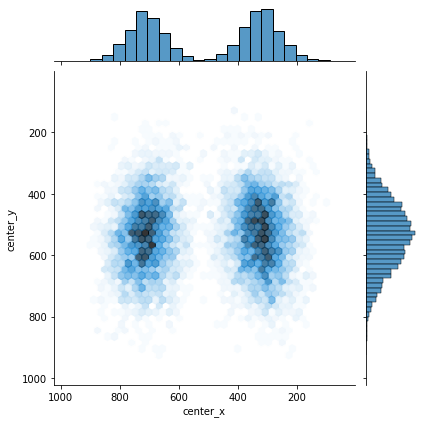

In [ ]:
# create a jointplot for patients for view position = AP
sns.jointplot(x = 'center_x', y = 'center_y', data = bboxes_data[bboxes_data['view_position']=='AP'], kind = 'hex', alpha = 0.8,xlim = 1024, ylim = 1024);

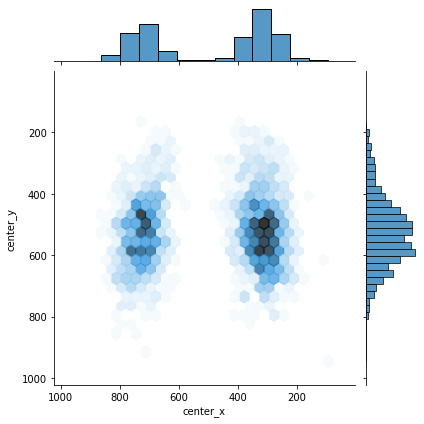

In [ ]:
# create a jointplot for patients for view position = PA
sns.jointplot(x = 'center_x', y = 'center_y', data = bboxes_data[bboxes_data['view_position']=='PA'], kind = 'hex', alpha = 0.8,xlim = 1024, ylim = 1024);

Some inferences that can be drawn from the above plots:

* For view position = AP, we can see a higher concentration of bounding box centers towards the center of the lungs especially on the left lung.

* For view position = PA, we can see a higher concentration of bounding boxes centers towards the center of the lungs predominantly on the left lung compared to the right lung.

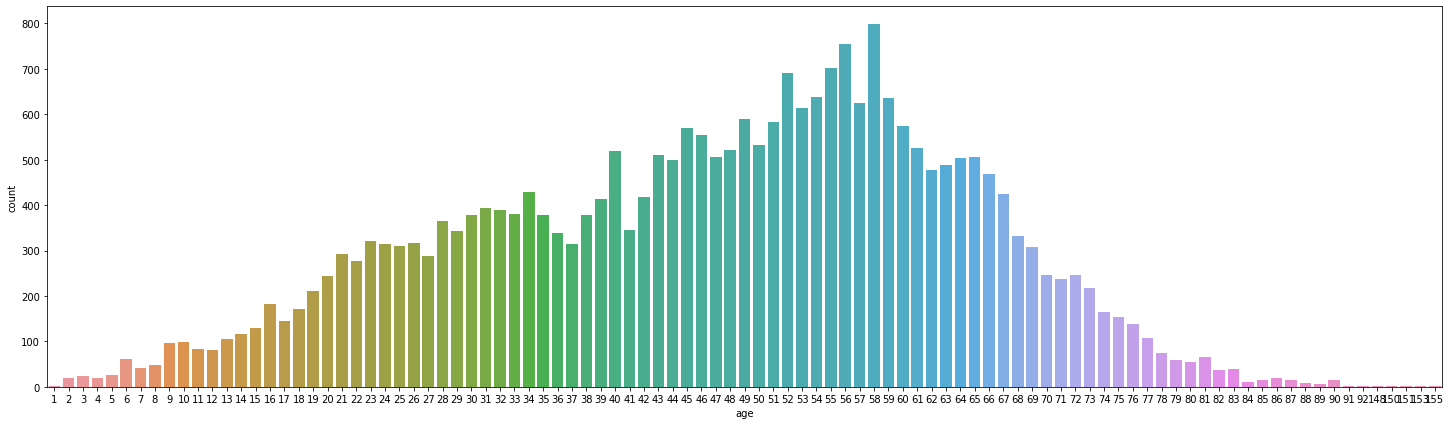

In [ ]:
# look at the age distribution of patients
countplt, ax = plt.subplots(figsize = (25,7))
ax = sns.countplot(x = 'age', data = final_data.drop_duplicates(subset="patientId",inplace=False));

We can see that for age = 58, we have the highest number of patients i.e. about 790

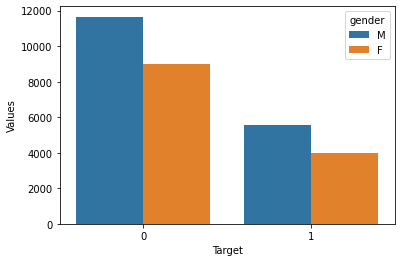

In [ ]:
# create a bar chart to show distribution of target by gender
target_gender_combined_df = pd.DataFrame(data = {'Values': final_data.groupby('Target')['gender'].value_counts().values}, 
                                        index = final_data.groupby('Target')['gender'].value_counts().index).reset_index()
sns.barplot(x = 'Target', y = 'Values', hue = 'gender', data = target_gender_combined_df);

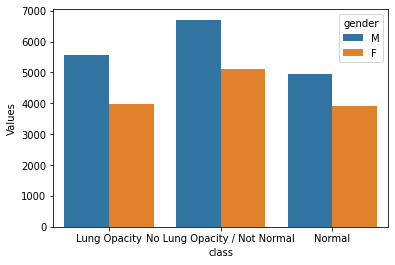

In [ ]:
# create a bar chart to show distribution of class by gender
class_gender_combined_df = pd.DataFrame(data = {'Values': final_data.groupby('class')['gender'].value_counts().values}, 
                                        index = final_data.groupby('class')['gender'].value_counts().index).reset_index()
sns.barplot(x = 'class', y = 'Values', hue = 'gender', data = class_gender_combined_df);

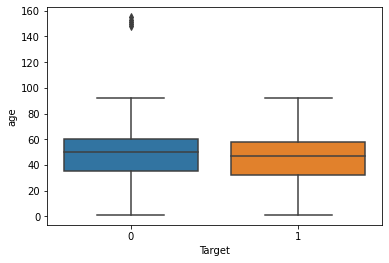

In [ ]:
# create a boxplot for age distribution by Target
sns.boxplot(x='Target', y='age', data= final_data);

* Age distribution is similar for normal patients and patients with pneumonia.
* Patients without pneumonia seems to have some outlier ages which are very high (140+) which is definitely erroneous. 

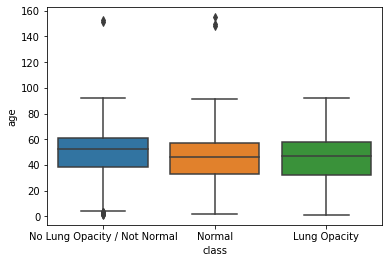

In [ ]:
# create a boxplot for age distribution by class
sns.boxplot(x='class', y='age', data= final_data);

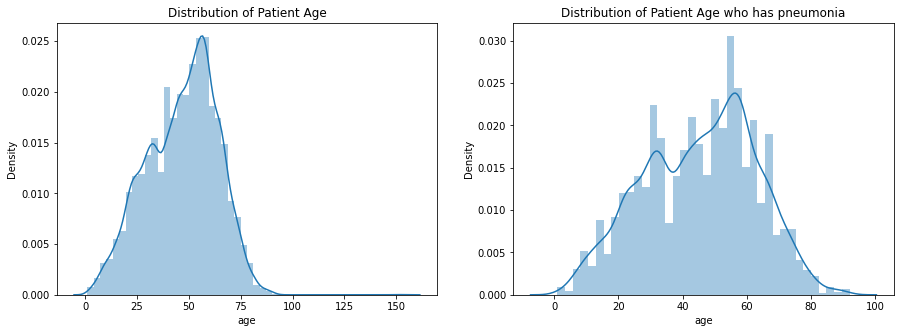

In [ ]:
# compare distribution of age overall vs patients who have pneumonia
fig = plt.figure(figsize = (15, 5))

ax = fig.add_subplot(121)
sns.distplot(final_data['age']).set_title('Distribution of Patient Age');

ax = fig.add_subplot(122)
sns.distplot(final_data.loc[final_data['Target'] == 1, 'age']).set_title('Distribution of Patient Age who has pneumonia');

* We can see some outlier age in the distribution of patient age with maximum age around 150 however for patients that has pneumonia, the age ranges till 100.

# **View images of patients**

100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


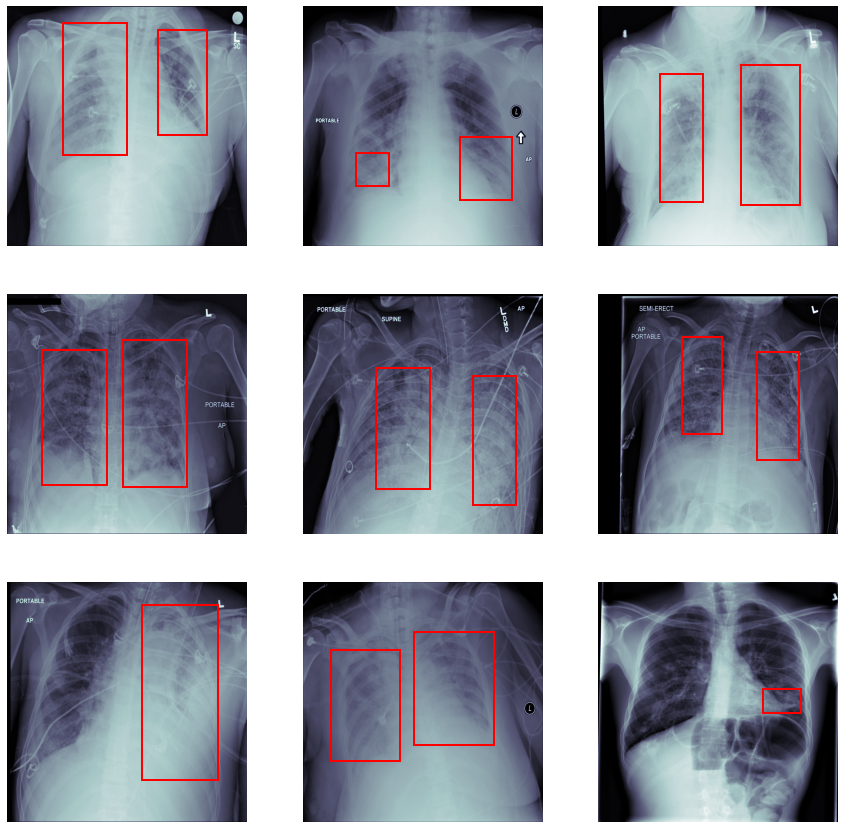

In [ ]:
# show images and bounding boxes for sample patients having pneumonia
sample_patients = train_data[train_data['Target']==1].sample(9).patientId
f, ax = plt.subplots(3,3, figsize=(15,15))
i=0
for p in tqdm(sample_patients):
    ds = dcm.dcmread('stage_2_train_images/' + p + '.dcm')
    ax[i//3, i%3].imshow(ds.pixel_array, cmap=plt.cm.bone) 
    ax[i//3, i%3].axis('off')
    bboxes_data=train_data[['x','y','width','height']][train_data['patientId']==p].values
    for box in bboxes_data:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            bb = patches.Rectangle((x, y), w, h, color='red', fill=False, linewidth=2)
            ax[i//3, i%3].add_patch(bb)
    i=i+1
        


100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


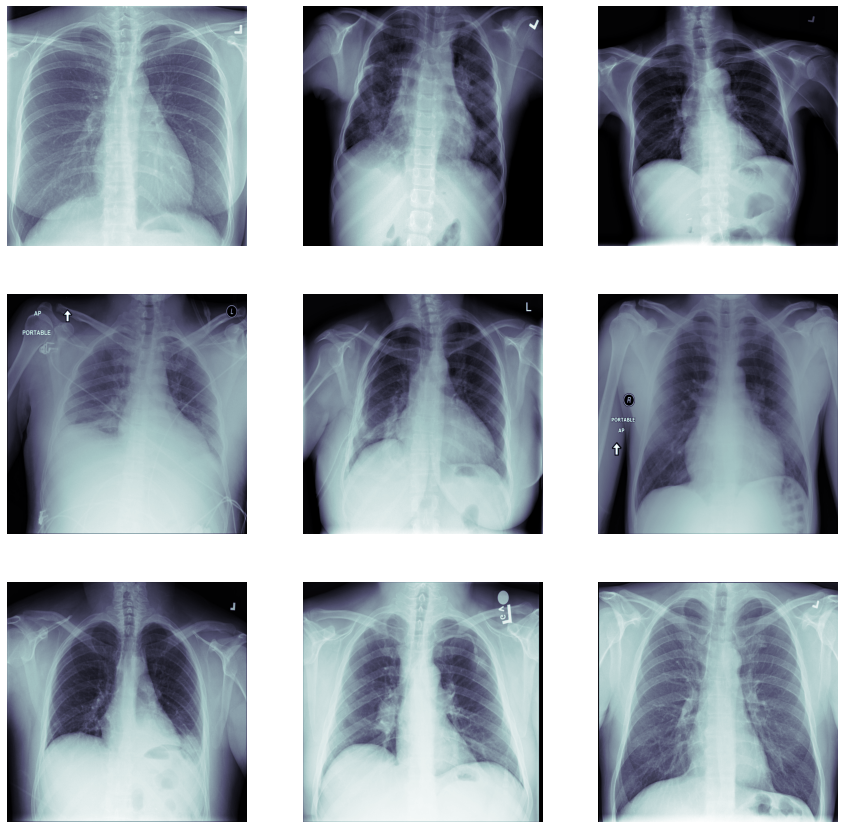

In [ ]:
# show images and bounding boxes for sample patients not having pneumonia
sample_patients = train_data[train_data['Target']==0].sample(9).patientId
f, ax = plt.subplots(3,3, figsize=(15,15))
i=0
for p in tqdm(sample_patients):
    ds = dcm.dcmread('stage_2_train_images/' + p + '.dcm')
    ax[i//3, i%3].imshow(ds.pixel_array, cmap=plt.cm.bone) 
    ax[i//3, i%3].axis('off')
    bboxes_data=train_data[['x','y','width','height']][train_data['patientId']==p].values
    for box in bboxes_data:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            bb = patches.Rectangle((x, y), w, h, color='red', fill=False, linewidth=2)
            ax[i//3, i%3].add_patch(bb)
    i=i+1
        

# **Model Building**

## CNN:

In [ ]:
## Just taking 300 samples of each class from the dataset
df_sample = df.groupby('class', group_keys=False).apply(lambda x: x.sample(300))
df_sample['class'].value_counts()


Lung Opacity                    300
No Lung Opacity / Not Normal    300
Normal                          300
Name: class, dtype: int64

#### Pre-processing

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = TRAIN_IMAGES+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels


In [ ]:
## Reading the images into numpy array
images,labels = populateImage(df_sample)

In [ ]:
images.shape , labels.shape


((900, 128, 128, 3), (900,))

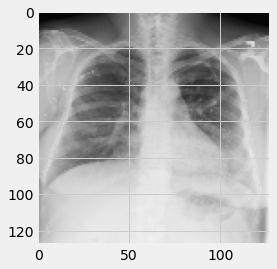

In [ ]:
## Checking one of the converted image 
plt.imshow(images[100])


##### Importing model building libraries

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [ ]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)


In [ ]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)


##### CNN Model without transfer learning

*   32 filters with 5x5 kernel
*   64 and then 128 with dropping
*   softmax layer at the end

In [ ]:
def model_cnn(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model


In [ ]:
# Model Summary
cnn = model_cnn(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [ ]:
## Training for 30 epocs with batch size of 30
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 30, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)


Epoch 1/30
21/21 [==============================] - 18s 795ms/step - loss: 10.1297 - accuracy: 0.3302 - val_loss: 1.0989 - val_accuracy: 0.3926
Epoch 2/30
21/21 [==============================] - 17s 796ms/step - loss: 1.1531 - accuracy: 0.3429 - val_loss: 1.0963 - val_accuracy: 0.3407
Epoch 3/30
21/21 [==============================] - 17s 790ms/step - loss: 1.1090 - accuracy: 0.3683 - val_loss: 1.0853 - val_accuracy: 0.4222
Epoch 4/30
21/21 [==============================] - 17s 795ms/step - loss: 1.1273 - accuracy: 0.3254 - val_loss: 1.0971 - val_accuracy: 0.3259
Epoch 5/30
21/21 [==============================] - 17s 793ms/step - loss: 1.1161 - accuracy: 0.3317 - val_loss: 1.0879 - val_accuracy: 0.3407
Epoch 6/30
21/21 [==============================] - 17s 791ms/step - loss: 1.1050 - accuracy: 0.3683 - val_loss: 1.0834 - val_accuracy: 0.3333
Epoch 7/30
21/21 [==============================] - 17s 799ms/step - loss: 1.1070 - accuracy: 0.3762 - val_loss: 1.0940 - val_accuracy: 0.348

In [ ]:
## evaluating the accuracy
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


5/5 [==============================] - 0s 69ms/step - loss: 1.0163 - accuracy: 0.4815
Test loss: 1.0163277387619019
Test accuracy: 0.48148149251937866


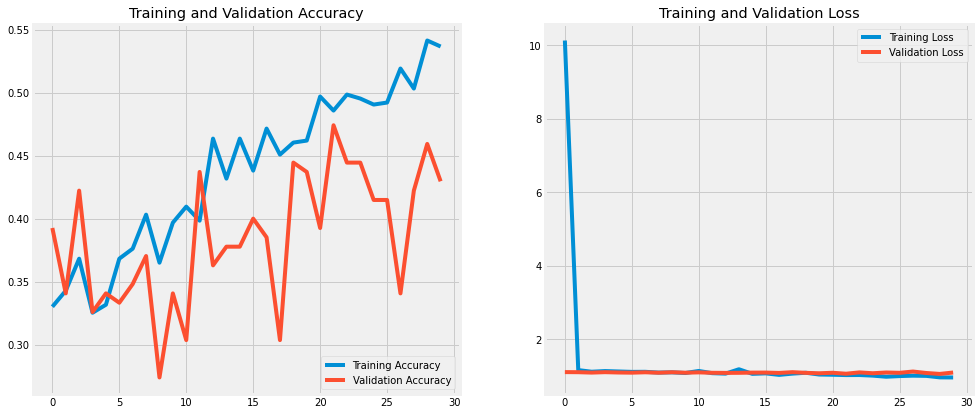

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


*   Highest training accuracy achieved is around 54%
*   Highest validation accuracy achieved is around 40%. 


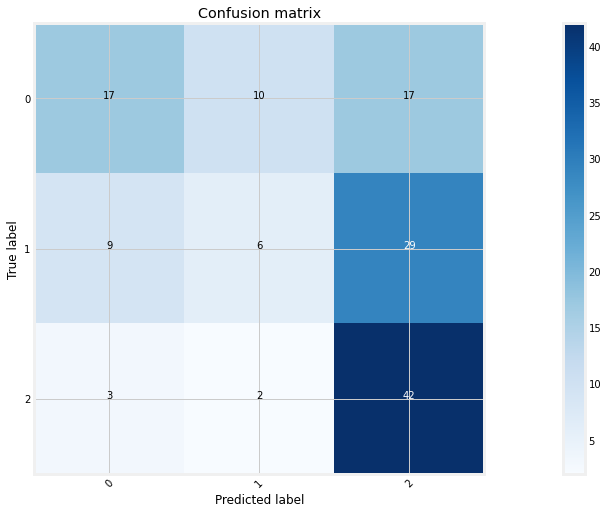

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))


*   Class 1 is lung opacity but not pneumonia. The model has got this mostly wrong. 

In [ ]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

#### CNN with transfer learning - VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 7 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val) ,callbacks=es)


Epoch 1/30
20/20 [==============================] - 9s 412ms/step - loss: 2.3255 - accuracy: 0.4683 - val_loss: 0.9282 - val_accuracy: 0.5407
Epoch 2/30
20/20 [==============================] - 8s 388ms/step - loss: 0.6047 - accuracy: 0.6952 - val_loss: 0.7954 - val_accuracy: 0.6222
Epoch 3/30
20/20 [==============================] - 8s 392ms/step - loss: 0.2565 - accuracy: 0.8603 - val_loss: 0.7797 - val_accuracy: 0.6000
Epoch 4/30
20/20 [==============================] - 8s 385ms/step - loss: 0.1447 - accuracy: 0.9381 - val_loss: 0.7154 - val_accuracy: 0.6444
Epoch 5/30
20/20 [==============================] - 8s 381ms/step - loss: 0.0881 - accuracy: 0.9762 - val_loss: 0.7618 - val_accuracy: 0.5926
Epoch 6/30
20/20 [==============================] - 8s 383ms/step - loss: 0.0560 - accuracy: 0.9937 - val_loss: 0.7654 - val_accuracy: 0.5926
Epoch 7/30
20/20 [==============================] - 8s 383ms/step - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.8402 - val_accuracy: 0.6000
Epoch 

In [ ]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


5/5 [==============================] - 2s 325ms/step - loss: 0.9292 - accuracy: 0.5778
Test loss: 0.9291670918464661
Test accuracy: 0.5777778029441833


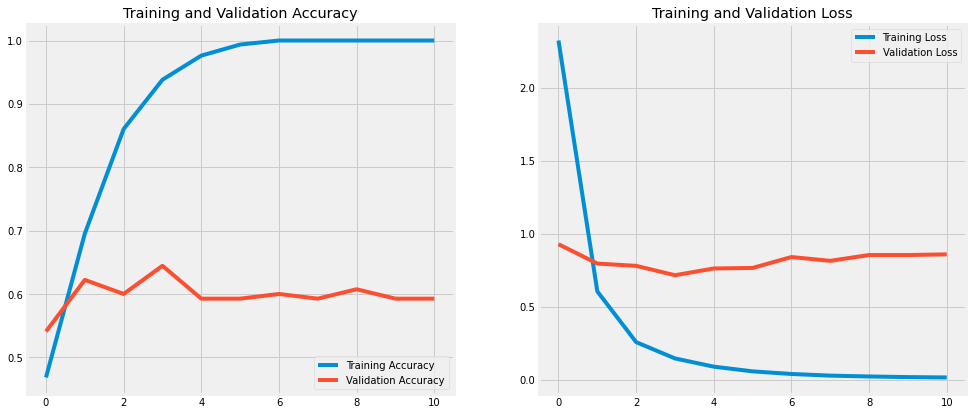

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(11)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**This is an overfit model. We see training accuracy of 100% but validation accuracy is closer to 60%.**

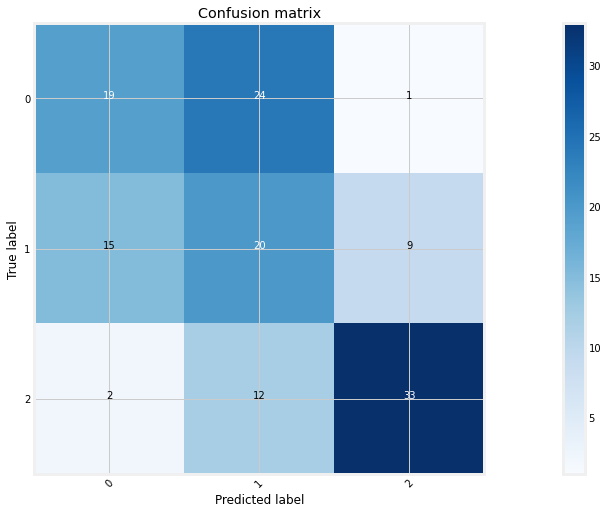

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn_VGG16_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

**Class 1 is better than plain CNN**

#### CNN with transfer learning - resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models


In [ ]:
resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

## Adding two hidden later and one softmax layer as an output layer
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))


Epoch 1/30
20/20 [==============================] - 36s 1s/step - loss: 0.8282 - accuracy: 0.5349 - val_loss: 1.9238 - val_accuracy: 0.3778
Epoch 2/30
20/20 [==============================] - 28s 1s/step - loss: 0.4517 - accuracy: 0.6873 - val_loss: 40.2575 - val_accuracy: 0.3333
Epoch 3/30
20/20 [==============================] - 27s 1s/step - loss: 0.4515 - accuracy: 0.7381 - val_loss: 54.7168 - val_accuracy: 0.3333
Epoch 4/30
20/20 [==============================] - 27s 1s/step - loss: 0.3422 - accuracy: 0.7952 - val_loss: 61.9813 - val_accuracy: 0.4074
Epoch 5/30
20/20 [==============================] - 26s 1s/step - loss: 0.2733 - accuracy: 0.8349 - val_loss: 61.4157 - val_accuracy: 0.4370
Epoch 6/30
20/20 [==============================] - 27s 1s/step - loss: 0.1959 - accuracy: 0.8968 - val_loss: 1.2821 - val_accuracy: 0.5852
Epoch 7/30
20/20 [==============================] - 26s 1s/step - loss: 0.1675 - accuracy: 0.9000 - val_loss: 4.3635 - val_accuracy: 0.6222
Epoch 8/30
20/20

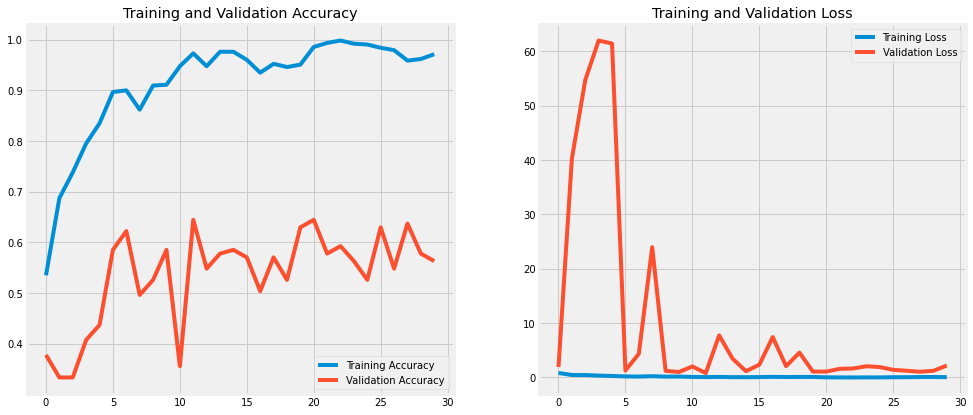

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Training accuracy reaches 100% again, but validation accuracy is closer to 70%**

In [ ]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)


5/5 [==============================] - 1s 245ms/step - loss: 1.9867 - accuracy: 0.6074
Test loss: 1.9866721630096436
Test accuracy: 0.6074073910713196


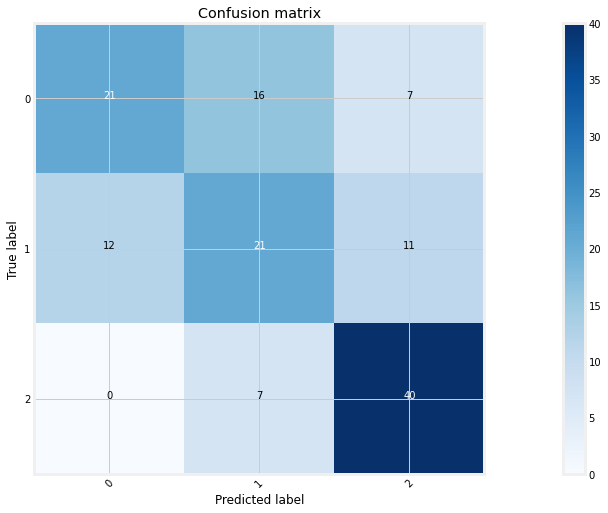

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))


**With ResNet50, Class 1 is a lot better than with ordinary CNN**

## *UNET using MOBILENET:*

### Initial Setup:

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D

### Data Selection:

For our modelling, we would consider the patients in the age range of 18 to 80. This would ensure that the effect of size of lungs is negated to a wide extent as the lungs of adults are more or less in the same size range.

In [ ]:
# filter the data to fetch data for patients in the age range 18 to 80
labels = final_data.loc[(final_data['age']>=18) & (final_data['age']<80)]

In [ ]:
labels.shape

(28381, 12)

In [ ]:
# check data distribition across class
labels['class'].value_counts()

No Lung Opacity / Not Normal    11222
Lung Opacity                     8828
Normal                           8331
Name: class, dtype: int64

In [ ]:
# check data distribition across gender
labels['gender'].value_counts()

M    16127
F    12254
Name: gender, dtype: int64

In [ ]:
# check data distribition across view position
labels['view_position'].value_counts()

AP    14192
PA    14189
Name: view_position, dtype: int64

In [ ]:
# check data distribition across target
labels['Target'].value_counts()

0    19553
1     8828
Name: Target, dtype: int64

Since the data size is huge and we have limited computational resources, we will take a sample of images for our model. We would take the first 5000 records for training and next 5000 records for validation.

In [ ]:
model_train_data = labels[0:5000]
model_validate_data = labels[5000:10000]

model_train_data.fillna(0, inplace=True)
model_validate_data.fillna(0, inplace=True)

In [ ]:
model_train_data.Target.value_counts()

0    2770
1    2230
Name: Target, dtype: int64

### Data Generator:

Due to our limited computational resources, we cannot load the entire set of 5000 images all at once because we will run out RAM to process it. So, we can create a data generator which would feed the images in batches to the model for training and validation. We will select a batch size of 8.

The generator code is created with reference to the following:
* https://github.com/lars76/object-localization/blob/master/example_2/train.py
* https://www.analyticsvidhya.com/blog/2021/08/explore-the-magic-methods-in-python/

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import Sequence

BATCH_SIZE = 8
IMAGE_SIZE = 128

## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024

class model_data_generator(Sequence):

    def __init__(self,  _labels): # define the init block to initialize the attributes of a class
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        
    def __len__(self): # define the len block to return the length of the instance attribute
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx): # define the getitem block to get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = 'stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = dcm.read_file(_path)
            img = _imgData.pixel_array 

            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
                 
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks

In [ ]:
train_generated = model_data_generator(model_train_data)
validate_generated = model_data_generator(model_validate_data)

### Defining the model Structure:

In [ ]:
# define a UNET model using MobileNet

def UNET_model(trainable=True):
    # create a MobileNet model with imagenet weights and do not include the top layer
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0, weights="imagenet") 
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_1 = model.get_layer("conv_pw_1_relu").output
    convLayer_2 = model.get_layer("conv_pw_3_relu").output
    convLayer_3 = model.get_layer("conv_pw_5_relu").output
    convLayer_4 = model.get_layer("conv_pw_11_relu").output
    convLayer_5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(convLayer_5), convLayer_4])
    x = Concatenate()([UpSampling2D()(x), convLayer_3])
    x = Concatenate()([UpSampling2D()(x), convLayer_2])
    x = Concatenate()([UpSampling2D()(x), convLayer_1])
    x = UpSampling2D(name="unet_last")(x)

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)

In [ ]:
# Create a model 
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = UNET_model(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_4[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']         

### Define Model Parameters:

In [ ]:
# define dice coefficient i.e. 2*the Area of Overlap divided by the total number of pixels in both images
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

## dice loss is 1-the dice coefficent
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
# Call Backs for ealy stopping and reduce learning rate 
## Reduce the learning rate when the validation loss is same for 4 epocs
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
## Optimiser , metrics and loss for the model
LR = 1e-4
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

### Model Execution:

In [ ]:
# Run the model
train_steps = len(train_generated)//BATCH_SIZE
valid_steps = len(validate_generated)//BATCH_SIZE

if len(train_generated) % BATCH_SIZE != 0:
    train_steps += 1
if len(validate_generated) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(train_generated,
                    epochs=16,
                    steps_per_epoch=train_steps,
                    validation_data=validate_generated,
                    callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=4,
                    validation_steps=valid_steps,                      
                    shuffle=True
                    )

Epoch 1/16
79/79 [==============================] - 396s 5s/step - loss: 0.8249 - dice_coef: 0.1751 - recall_1: 0.5639 - precision_1: 0.1159 - val_loss: 0.9769 - val_dice_coef: 0.0231 - val_recall_1: 0.0249 - val_precision_1: 0.2931 - lr: 1.0000e-04
Epoch 2/16
79/79 [==============================] - 442s 6s/step - loss: 0.7698 - dice_coef: 0.2302 - recall_1: 0.5029 - precision_1: 0.1857 - val_loss: 0.8554 - val_dice_coef: 0.1446 - val_recall_1: 0.3958 - val_precision_1: 0.2243 - lr: 1.0000e-04
Epoch 3/16
79/79 [==============================] - 371s 5s/step - loss: 0.7412 - dice_coef: 0.2588 - recall_1: 0.5223 - precision_1: 0.2099 - val_loss: 0.8725 - val_dice_coef: 0.1275 - val_recall_1: 0.3093 - val_precision_1: 0.2159 - lr: 1.0000e-04
Epoch 4/16
79/79 [==============================] - 388s 5s/step - loss: 0.7193 - dice_coef: 0.2807 - recall_1: 0.4855 - precision_1: 0.2424 - val_loss: 0.8578 - val_dice_coef: 0.1422 - val_recall_1: 0.3235 - val_precision_1: 0.2176 - lr: 1.0000e-04


The model ended with a training dice coefficient of 0.36 and a validation dice coefficient of 0.21.

The dice coefficient could increase by:
* increasing the sample size
* increasing the number of epochs
* increasing the image size used in the model i.e. 128

### Model Evaluation:

In [ ]:
# Preparing test data 
model_test_data = labels[11000:11020]
model_test_data.fillna(0, inplace=True)

In [ ]:
# Check target distrubution in test dataset
model_test_data.Target.value_counts()

0    11
1     9
Name: Target, dtype: int64

The test data has enough cases from both the target cases.

In [ ]:
# Generator for test data
test_generated = model_data_generator(model_test_data)

In [ ]:
# evaluating the model
test_steps = (len(test_generated)//BATCH_SIZE)
if len(test_generated) % BATCH_SIZE != 0:
    test_steps += 1

model.evaluate(test_generated)

3/3 [==============================] - 4s 1s/step - loss: 0.8366 - dice_coef: 0.1499 - recall_1: 0.5066 - precision_1: 0.1773


[0.8366280794143677,
 0.1499134749174118,
 0.5066179633140564,
 0.17731629312038422]

We get a dice coefficient of 0.15 which is again too low.

### Model Prediction:

In [ ]:
# predict mask
pred_mask = model.predict(test_generated)

In [ ]:
model_test_data = model_test_data.reset_index()

In [ ]:
y_pred = []
y_True = []
imageList = []
predMaskTemp = []
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

def predict(model_test_data):
    masks = np.zeros((int(model_test_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
    for index, row in model_test_data.iterrows():
        patientId = row.patientId
        classlabel = row["Target"]
        dcm_file = 'stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1    
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)

In [ ]:
# Create predictions
y_true,y_pred ,imagelist , maskList , originalMask = predict(model_test_data)

### Evaluation Metrics:

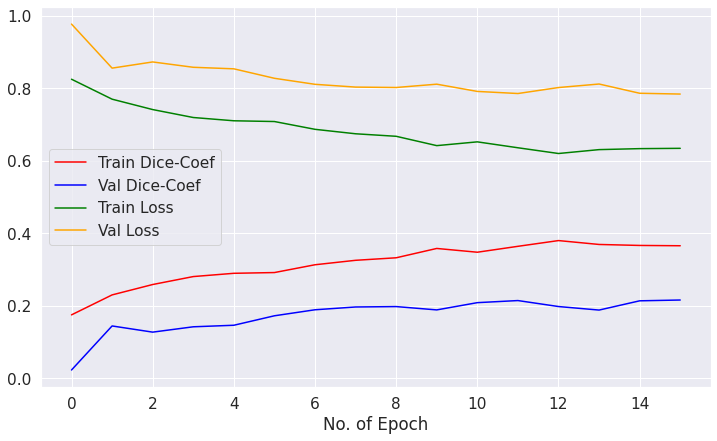

In [ ]:
# Plot training and validation data
plt.figure(figsize=(12, 7))
plt.plot(history.history['dice_coef'],label='Train Dice-Coef',color = "red" );
plt.plot(history.history['val_dice_coef'],label='Val Dice-Coef',color = "blue");
plt.plot(history.history['loss'],label='Train Loss',color = "green");
plt.plot(history.history['val_loss'],label='Val Loss',color = "orange");
plt.xlabel("No. of Epoch")
plt.legend();

We can see a steady increase in the train and validation dice coefficient. This means that if we would have used more number of epochs then the model would have generalized better.

In [ ]:
from sklearn.metrics import confusion_matrix
def view_confusion_matrix(y_true, y_pred):
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))
    print("Total samples = ", len(model_test_data))
    # Plot heatmap and get sns heatmap values
    result = sns.heatmap(df_cm, annot=True, fmt='g', cbar=False); 
    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
        plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return

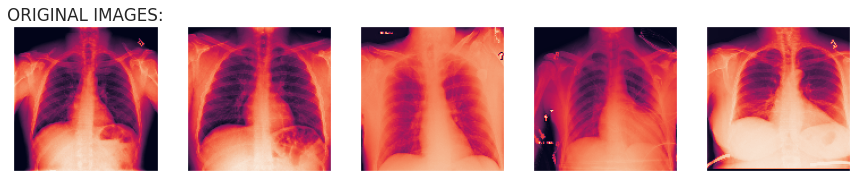

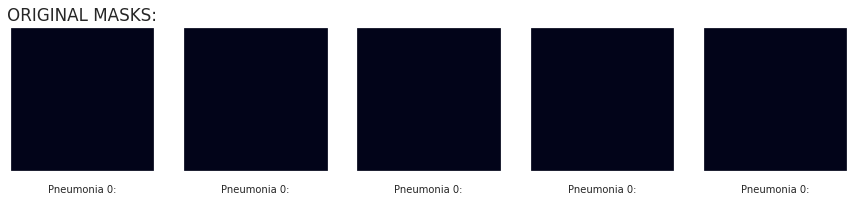

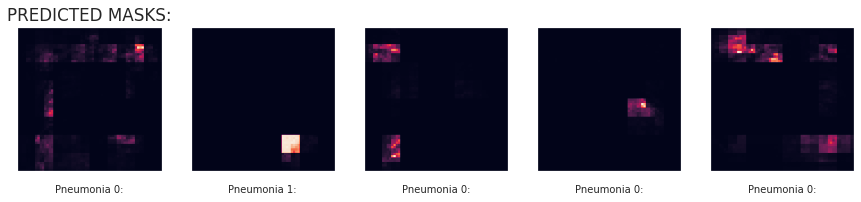

In [ ]:
# Visualising the 1st 5 records from test data so see how our model predicted the bounding boxes

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL IMAGES:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(imagelist[i])

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(originalMask[i])
  a.set_xlabel('Pneumonia {}:'.format(y_true[i]), fontsize=10)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('PREDICTED MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(maskList[i])
  a.set_xlabel('Pneumonia {}:'.format(y_pred[i]), fontsize=10)


* Image 1: Correct prediction
* Image 2: Wrong prediction
* Image 3: Correct prediction
* Image 4: Correct prediction
* Image 5: Correct prediction

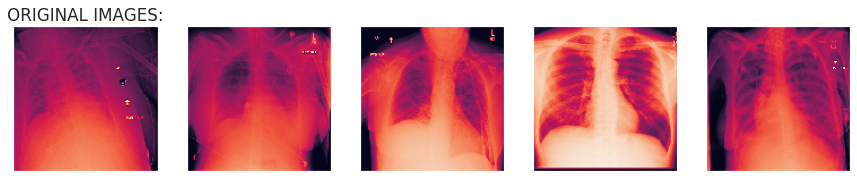

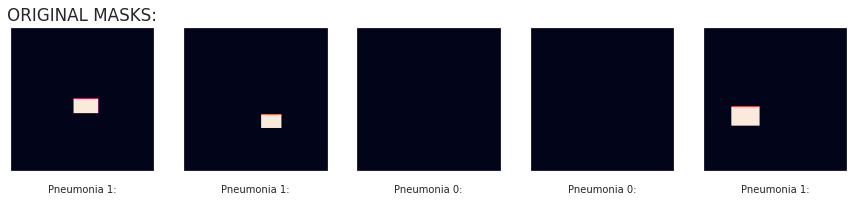

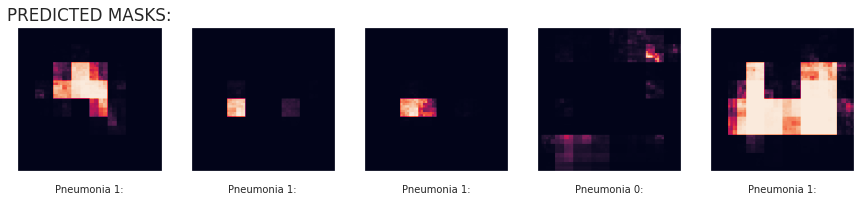

In [ ]:
# Visualising the next 5 records from test data so see how our model predicted the bounding boxes

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL IMAGES:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(imagelist[i+5])

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(originalMask[i+5])
  a.set_xlabel('Pneumonia {}:'.format(y_true[i+5]), fontsize=10)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('PREDICTED MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(maskList[i+5])
  a.set_xlabel('Pneumonia {}:'.format(y_pred[i+5]), fontsize=10)


* Image 6: Correct prediction, Bounding box location correct but size incorrect
* Image 7: Wrong prediction, Bounding box at wrong position
* Image 8: Wrong prediction 
* Image 9: Correct prediction
* Image 10: Correct prediction, Bounding box location correct but size incorrect

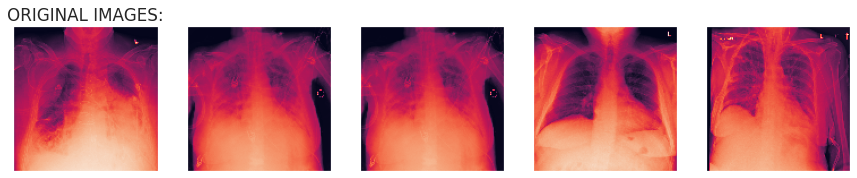

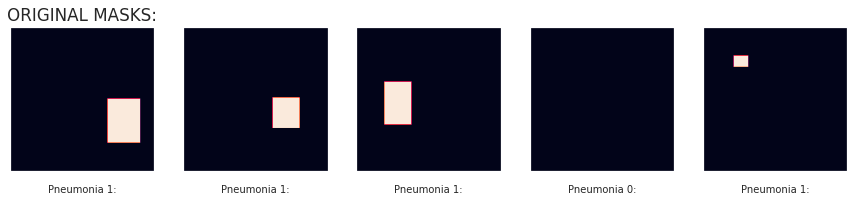

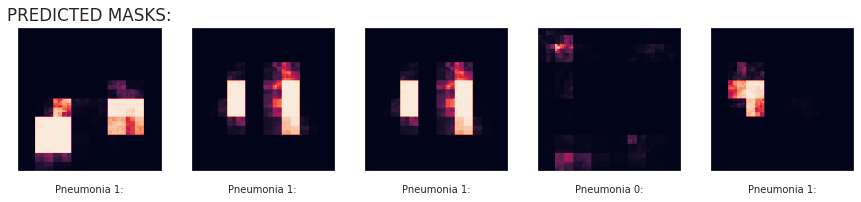

In [ ]:
# Visualising the next 5 records from test data so see how our model predicted the bounding boxes

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL IMAGES:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(imagelist[i+10])

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(originalMask[i+10])
  a.set_xlabel('Pneumonia {}:'.format(y_true[i+10]), fontsize=10)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('PREDICTED MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(maskList[i+10])
  a.set_xlabel('Pneumonia {}:'.format(y_pred[i+10]), fontsize=10)

* Image 11: Correct prediction, Bounding box location correct but there are 2 bounding boxes predicted
* Image 12: Correct prediction, Bounding box location correct but there are 2 bounding boxes predicted
* Image 13: Correct prediction, Bounding box location correct but there are 2 bounding boxes predicted
* Image 14: Correct prediction
* Image 15: Correct prediction, Bounding box location correct but size incorrect

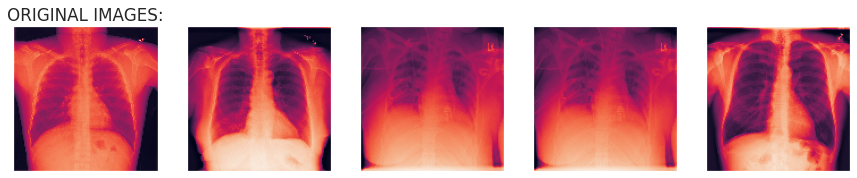

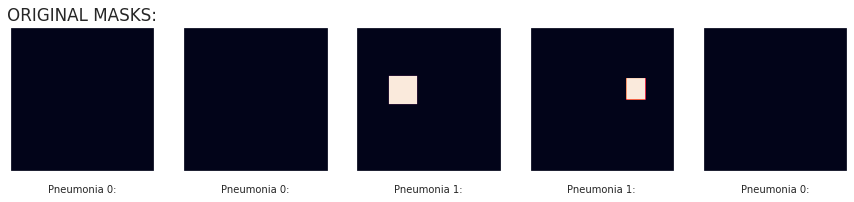

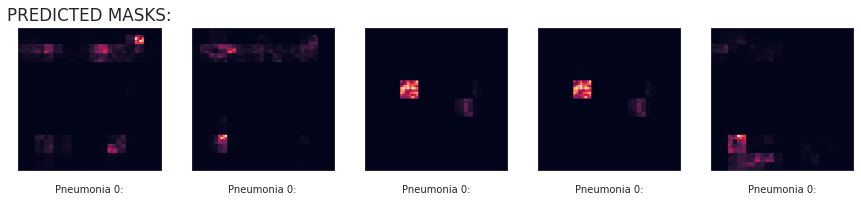

In [ ]:
# Visualising the next 5 records from test data so see how our model predicted the bounding boxes

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL IMAGES:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(imagelist[i+15])

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('ORIGINAL MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(originalMask[i+15])
  a.set_xlabel('Pneumonia {}:'.format(y_true[i+15]), fontsize=10)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 5, 1)
a.set_title('PREDICTED MASKS:')
for i in range(0,5):
  a = fig.add_subplot(1, 5, i+1)
  a.grid(False)
  a.set_yticklabels([])
  a.set_xticklabels([])
  imgplot = plt.imshow(maskList[i+15])
  a.set_xlabel('Pneumonia {}:'.format(y_pred[i+15]), fontsize=10)

* Image 11: Correct prediction
* Image 12: Correct prediction
* Image 13: Wrong prediction
* Image 14: Wrong prediction
* Image 15: Correct prediction

In [ ]:
y_true,y_pred

([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0],
 [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.78      0.78      0.78         9

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.80      0.80      0.80        20



Total samples =  20


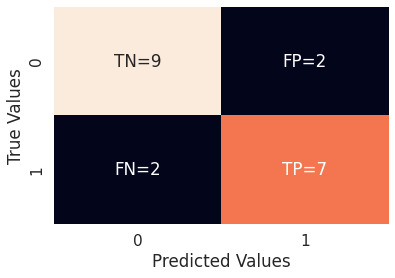

In [ ]:
view_confusion_matrix(y_true,y_pred )

## Object Detection API:

### Initial Setup:

In [ ]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 75150, done.
remote: Counting objects: 100% (638/638), done.
remote: Compressing objects: 100% (296/296), done.
remote: Total 75150 (delta 387), reused 554 (delta 336), pack-reused 74512
Receiving objects: 100% (75150/75150), 580.61 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (53281/53281), done.
Checking out files: 100% (3088/3088), done.


In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf1/setup.py .
python -m pip install --use-feature=2020-resolver .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694773 sha256=674f4ed44622e0f2f1012809a9013705fbf6903ca77ae9adaf3013a27cc9d54e
  Stored in directory: /tmp/pip-ephem-wheel-cache-msdmzvrd/wheels/e6/c1/18/603c78a1d07674da9fa184a8776b991d4c4633fc9ae8355d11
Successfully built object-detection


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tf_models_official-2.9.2-py2.py3-none-any.whl (2.1 MB)
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 4.6 MB 9.5 MB/s 
  Using cached py-cpuinfo-8.0.0.tar.gz (99 kB)
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 237 kB 39.0 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 92 kB 10.9 MB/s 
     |████████████████████████████████| 352 kB 59.6 MB/s 
  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
     |████████████████████████████████| 636 kB 53.6 MB/s 
     |████████████████████████████████| 1.6 MB 22.9 MB/s 
     |████████████████████████████████| 5.8 MB 24.5 MB/s 
     |█████████████████████████████

In [ ]:
!pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opencv-python==4.6.0.66

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 102 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip list | grep object-detection

### Data Selection:

In [ ]:
labels_metadata_class_df = final_data

In [ ]:
df_0 = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'M') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'No Lung Opacity / Not Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'PA')].head(75)

In [ ]:
df_0_AP = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'M') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'No Lung Opacity / Not Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'AP')].head(75)

In [ ]:
df_0_Normal = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'M') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'PA')].head(75)

In [ ]:
df_0_Normal_AP = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'M') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'AP')].head(75)

In [ ]:
df_0_F = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'F') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'No Lung Opacity / Not Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'PA')].head(75)

In [ ]:
df_0_F_AP = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'F') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'No Lung Opacity / Not Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'AP')].head(75)

In [ ]:
df_0_Normal_F = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'F') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'PA')].head(75)

In [ ]:
df_0_Normal_F_AP = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'F') & 
                         (labels_metadata_class_df['Target'] == 0) & 
                         (labels_metadata_class_df['class'] == 'Normal') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'AP')].head(75)

In [ ]:
df_1_M = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'M') & 
                         (labels_metadata_class_df['Target'] == 1) & 
                         (labels_metadata_class_df['class'] == 'Lung Opacity') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'PA')]

df_1_M = df_1_M[df_1_M.patientId.isin(df_1_M.patientId.unique()[:100])]

In [ ]:
df_1_M_AP = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'M') & 
                         (labels_metadata_class_df['Target'] == 1) & 
                         (labels_metadata_class_df['class'] == 'Lung Opacity') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'AP')]

df_1_M_AP = df_1_M_AP[df_1_M_AP.patientId.isin(df_1_M_AP.patientId.unique()[:100])]

In [ ]:
df_1_F = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'F') & 
                         (labels_metadata_class_df['Target'] == 1) & 
                         (labels_metadata_class_df['class'] == 'Lung Opacity') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'PA')]

df_1_F = df_1_F[df_1_F.patientId.isin(df_1_F.patientId.unique()[:100])]

In [ ]:
df_1_F_AP = labels_metadata_class_df[(labels_metadata_class_df['gender'] == 'F') & 
                         (labels_metadata_class_df['Target'] == 1) & 
                         (labels_metadata_class_df['class'] == 'Lung Opacity') &
                         (labels_metadata_class_df['age'] > 18) &
                         (labels_metadata_class_df['age'] < 100) &
                         (labels_metadata_class_df['view_position'] == 'AP')]

df_1_F_AP = df_1_F_AP[df_1_F_AP.patientId.isin(df_1_F_AP.patientId.unique()[:100])]

In [ ]:
pd.concat([
    pd.concat([df_0, df_0_AP], axis=0), pd.concat([df_0_Normal, df_0_Normal_AP], axis=0),
    pd.concat([df_0_F, df_0_F_AP], axis=0), pd.concat([df_0_Normal_F, df_0_Normal_F_AP], axis=0),
    pd.concat([df_1_M, df_1_M_AP], axis=0), pd.concat([df_1_F, df_1_F_AP], axis=0)]).to_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/Object_Detection_API_Data.csv', index=False)

In [ ]:
labels_metadata_class_df.to_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/All_Data.csv')

### Data Generator:

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/Object_Detection_API_Data.csv')

In [ ]:
train_df.head()

patientId   x   y  width  height  Target  \
0  006cec2e-6ce2-4549-bffa-eadfcd1e9970 NaN NaN    NaN     NaN       0   
1  00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b NaN NaN    NaN     NaN       0   
2  011d6f51-b732-4d45-a84d-90477325ef2d NaN NaN    NaN     NaN       0   
3  016b1f90-bb9a-4d3a-9c38-74af5fffd5b5 NaN NaN    NaN     NaN       0   
4  019e035e-2f82-4c66-a198-57422a27925f NaN NaN    NaN     NaN       0   

                          class  age gender view_position  center_x  center_y  
0  No Lung Opacity / Not Normal   78      M            PA       NaN       NaN  
1  No Lung Opacity / Not Normal   70      M            PA       NaN       NaN  
2  No Lung Opacity / Not Normal   52      M            PA       NaN       NaN  
3  No Lung Opacity / Not Normal   54      M            PA       NaN       NaN  
4  No Lung Opacity / Not Normal   44      M            PA       NaN       NaN

In [ ]:
train_df.shape

(1218, 12)

In [ ]:
train_df.age.min(), train_df.age.max()

(19, 87)

In [ ]:
import pydicom as dcm
from PIL import Image

In [ ]:
for name in tqdm(train_df.patientId.unique()):
  ds = dcm.dcmread(r"/content/drive/MyDrive/AIML2021/Capstone/stage_2_train_images/" + name + ".dcm")
  img = Image.fromarray(ds.pixel_array)
  img.save("/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/TrainJPEGImages/" + name + ".jpeg")

100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


In [ ]:
train_df.rename(columns = {'patientId':'filename', 'x':'xmin', 'y':'ymin', 'Target':'label'}, inplace = True)

In [ ]:
train_df.fillna(0, inplace=True)

In [ ]:
train_df['xmin'] = train_df['xmin'].astype(np.int64)
train_df['ymin'] = train_df['ymin'].astype(np.int64)
train_df['width'] = train_df['width'].astype(np.int64)
train_df['height'] = train_df['height'].astype(np.int64)

In [ ]:
train_df['xmax'] = train_df['xmin'] +  train_df['width']
train_df['ymax'] = train_df['ymin'] +  train_df['height']

In [ ]:
train_df['height'] = 1024
train_df['width'] = 1024

In [ ]:
train_df.head()

filename  xmin  ymin  width  height  label  \
0  006cec2e-6ce2-4549-bffa-eadfcd1e9970     0     0   1024    1024      0   
1  00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b     0     0   1024    1024      0   
2  011d6f51-b732-4d45-a84d-90477325ef2d     0     0   1024    1024      0   
3  016b1f90-bb9a-4d3a-9c38-74af5fffd5b5     0     0   1024    1024      0   
4  019e035e-2f82-4c66-a198-57422a27925f     0     0   1024    1024      0   

                          class  age gender view_position  center_x  center_y  \
0  No Lung Opacity / Not Normal   78      M            PA       0.0       0.0   
1  No Lung Opacity / Not Normal   70      M            PA       0.0       0.0   
2  No Lung Opacity / Not Normal   52      M            PA       0.0       0.0   
3  No Lung Opacity / Not Normal   54      M            PA       0.0       0.0   
4  No Lung Opacity / Not Normal   44      M            PA       0.0       0.0   

   xmax  ymax  
0     0     0  
1     0     0  
2     0     0  
3     0     0  
4     0     0

In [ ]:
train_df.drop(['age', 'gender', 'view_position','center_x','center_y'], axis=1, inplace=True)

In [ ]:
train_df['label'] = train_df['label'] + 1

### Save different files that can be reused for object detection API:
*   All_Data.csv - All patient records with all atributes (x, y, width, height, Target, age, gender, view_position, class)
*   Train.csv - object detection API model training (formatted file to get in specific format required for API, sublist of selected 1000 patients)
*   Test.csv - object detection API model evaluation (formatted file to get in specific format required for API, sublist of selected 1000 patients)
*   OD_API_tfRecord_Data.csv - Used for tfrecord creation. API expects tfrecords as input (list of 1000 patients)


In [ ]:
train_df.to_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/OD_API_tfRecord_Data.csv')

In [ ]:
#Create a dictionary of Label and Class. This will be useful for building our second input to Model training
label_class_dict = dict(zip(train_df['label'], train_df['class']))
print(label_class_dict)

{1: 'Normal', 2: 'Lung Opacity'}


In [ ]:
label_class_dict

pbtxt_file_txt = ''
for label in sorted(label_class_dict.keys()):
    
    pbtxt_file_txt += "item {\n  id: " + str(label) + "\n  name: '" +  label_class_dict[label] + "'\n}\n\n"

with open('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/label_map.txt','w') as pbfile:
    pbfile.write(pbtxt_file_txt)

In [ ]:
#Review the file content
!cat '/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/label_map.txt'

item {
  id: 1
  name: 'Normal'
}

item {
  id: 2
  name: 'Lung Opacity'
}



In [ ]:
#Get information on all images
all_classes = train_df['filename'].unique()
all_classes.shape

(1000,)

In [ ]:
#Split images between training and test
import numpy as np

#80% of the data will be used for training
mask = np.random.rand(all_classes.shape[0]) < 0.8

#Get Training and Test images
train_images = all_classes[mask]
test_images = all_classes[~mask] 

In [ ]:
#Check number of images in training and test
train_images.shape, test_images.shape

((802,), (198,))

In [ ]:
#Split dataframe between training and test
train_df_1 = train_df[train_df['filename'].isin(train_images)]
test_df_1 = train_df[train_df['filename'].isin(test_images)]

In [ ]:
train_df_1['filename'] = train_df_1['filename'] + '.jpeg'

In [ ]:
test_df_1['filename'] = test_df_1['filename'] + '.jpeg'

In [ ]:
train_df_1.to_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/train.csv')
test_df_1.to_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/test.csv')
all_data_df = pd.read_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/All_Data.csv')
od_detection_data_df = pd.read_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/Object_Detection_API_Data.csv')

In [ ]:
df_all = all_data_df.merge(od_detection_data_df, on=['patientId'], 
                   how='left', indicator=True)

### Select files for testing API:

In [ ]:
test_images = df_all[df_all['_merge'] == 'left_only'].head(10)

In [ ]:
for row in test_images.iterrows():
  name = row[1][1]
  print(name)

00aecb01-a116-45a2-956c-08d2fa55433f
00aecb01-a116-45a2-956c-08d2fa55433f
01be392f-a46d-4aef-a57e-9cd1a80dd47e
01be392f-a46d-4aef-a57e-9cd1a80dd47e
01ee3bcb-d6a8-4586-b0a5-9647969da07d
01fa0f5e-00c3-41cb-b5c7-10600c8633ae
01fa0f5e-00c3-41cb-b5c7-10600c8633ae
01fdfd88-7607-48b9-ba05-a36e8b6fd19b
01fdfd88-7607-48b9-ba05-a36e8b6fd19b
02051597-8a40-4586-88e1-8e62e421981f


In [ ]:
for row in test_images.iterrows():
  name = row[1][1]
  ds = dcm.dcmread(r"/content/drive/MyDrive/AIML2021/Capstone/stage_2_train_images/" + name + ".dcm")
  img = Image.fromarray(ds.pixel_array)
  img.save("/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/TestJPEGImages/" + name + ".jpeg")

### Define Model Structure & Parameters:

In [ ]:
img_path = r'/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/TrainJPEGImages'

In [ ]:
# set google drive path
%cd "/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API"

/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API


**Download SSD with Mobilenet model**

In [ ]:
#Download the model from zoo
!wget -q http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!ls -l
#Extract tar file content
!tar -xf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
!ls -l
#Check the extracted folder
!ls -l ssd_mobilenet_v2_320x320_coco17_tpu-8
#Check the extracted folder
!ls -l ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint

total 154655
-rw------- 1 root root  2586734 Jul  8 02:55 All_Data.csv
drwx------ 2 root root     4096 Jul  7 08:41 detection_model
-rw------- 1 root root     7577 Jul  7 08:40 exporter_main_v2.py
-rw------- 1 root root     4465 Jul  5 19:33 generate_tfrecord.py
-rw------- 1 root root       76 Jul  8 03:05 label_map.txt
-rw------- 1 root root     4918 Jul  5 19:32 model_main_tf2.py
-rw------- 1 root root    80138 Jul  5 19:31 Object_Detection_API_Data_Creator.ipynb
-rw------- 1 root root   101916 Jul  8 02:55 Object_Detection_API_Data.csv
-rw------- 1 root root   542718 Jul  5 19:23 Object_Detection_API_Model.ipynb
-rw------- 1 root root    98186 Jul  8 03:05 OD_API_tfRecord_Data.csv
drwx------ 2 root root     4096 Jul 11  2020 ssd_mobilenet_v2_320x320_coco17_tpu-8
-rw------- 1 root root 46042990 Jul 11  2020 ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
-rw------- 1 root root 46042990 Jul 11  2020 ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz.1
-rw------- 1 root root     4361 Jul  5 19:

In [ ]:
!cp /content/drive/MyDrive/AIML2021/Capstone/models/research/object_detection/model_main_tf2.py .

In [ ]:
!cp /content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/generate_tfrecord.py .

In [ ]:
!cp /content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/ssd_mobilenet_v2_modified.config .

In [ ]:
#generate tfrecord for training data
!python generate_tfrecord.py --csv_input=train.csv  --img_path={img_path} --output_path=train.tfrecord

2022-07-08 03:09:37.442162: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/train.tfrecord


In [ ]:
#generate tfrecord for test data
!python generate_tfrecord.py --csv_input=test.csv  --img_path={img_path} --output_path=test.tfrecord

2022-07-08 03:09:52.787080: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Successfully created the TFRecords: /content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/test.tfrecord


In [ ]:
config_file = '/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/ssd_mobilenet_v2_modified.config'

### Model Execution:

In [ ]:
#start training
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_every_n=5 --alsologtostderr

2022-07-08 03:10:07.132714: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W0708 03:10:07.135590 139828246730624 cross_device_ops.py:1386] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0708 03:10:07.141573 139828246730624 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0708 03:10:07.398766 139828246730624 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0708 03:10:07.399064 139828246730624 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0708 03:10:07.452928 139828246730624 deprecation.py:356] From /usr/local/

In [ ]:
#start Evaluation
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_dir=training/ --alsologtostderr 

2022-07-08 03:34:21.201900: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W0708 03:34:21.212040 140712489940864 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0708 03:34:21.212351 140712489940864 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0708 03:34:21.212472 140712489940864 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0708 03:34:21.212570 140712489940864 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0708 03:34:21.212705 140712489940864 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:Reading unweighted datase

### Export and save the model:

In [ ]:
#Copy export_inference_graph.py file from models/research/object_detection to current directory
!cp /content/drive/MyDrive/AIML2021/Capstone/models/research/object_detection/exporter_main_v2.py .

In [ ]:
#Provide input name, config file location, training folder
!python exporter_main_v2.py --input_type "image_tensor" --pipeline_config_path {config_file} --trained_checkpoint_dir training/ --output_directory detection_model

2022-07-08 03:35:35.535322: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0708 03:35:35.737544 139674616973184 deprecation.py:628] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of additional conv before box predictor: 0
I0708 03:35:42.640425 13

In [ ]:
#Check if model is saved in current directory
!ls -l detection_model

total 13
drwx------ 2 root root 4096 Jul  8 03:35 checkpoint
-rw------- 1 root root 4187 Jul  8 03:36 pipeline.config
drwx------ 4 root root 4096 Jul  8 03:36 saved_model


### Model Prediction:

In [ ]:
saved_model_path = '/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/detection_model/saved_model'
model = tf.saved_model.load(saved_model_path)

In [ ]:
all_data_df = pd.read_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/OD_API_tfRecord_Data.csv')

In [ ]:
#Create a dictionary of Label and Class. This will be useful for building our second input to Model training
label_class_dict = dict(zip(all_data_df['label'], all_data_df['class']))
print(label_class_dict)

{1: 'Normal', 2: 'Lung Opacity'}


In [ ]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    # print(output)
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    print(detection_scores)
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(label_class_dict[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
def visualize_output(image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)

    #Read image
    img = cv2.imread(image_file)

    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):

        box = output['Box coordinates'][i]
        
        #Draw rectangle - (ymin, xmin, ymax, xmax)
        img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 2)
        
        #Add Label - Class name and confidence level
        label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.show()

In [ ]:
#Model output
detector_prediction('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/TestJPEGImages/01be392f-a46d-4aef-a57e-9cd1a80dd47e.jpeg', confidence_threshold=0.5)

[0.8578036  0.65730727 0.6398243  0.40299782 0.3800182  0.3685947
 0.36843145 0.35739338 0.3511932  0.34420705 0.28462553 0.27002537
 0.26659605 0.26213562 0.2543513  0.25065452 0.24976692 0.24970844
 0.22793928 0.2087478  0.20806992 0.19977319 0.19439876 0.18080488
 0.18015546 0.17968756 0.17948925 0.17382473 0.1681422  0.1663431
 0.16572425 0.16505328 0.16225502 0.16071302 0.1605855  0.15833238
 0.15564793 0.15467012 0.15436861 0.14845115 0.14474592 0.1435146
 0.14108932 0.1407778  0.13986906 0.1361801  0.13315329 0.13230875
 0.13182154 0.12679952 0.12357521 0.11947855 0.11712039 0.11546516
 0.11524311 0.11314386 0.11015445 0.10971892 0.10721844 0.10712311
 0.10598493 0.10467243 0.10412803 0.10168529 0.10152355 0.10131907
 0.10042253 0.10021922 0.09980732 0.09965995 0.09826112 0.09705558
 0.09582606 0.09513107 0.09197214 0.09143785 0.08935273 0.08928263
 0.08816209 0.0873006  0.08708528 0.08689818 0.08683345 0.08651367
 0.0860247  0.0858441  0.08553997 0.08532116 0.0851419  0.0850186

{'Box coordinates': array([[ 558,  422,  941,  735],
        [ 685,  403, 1011,  735],
        [ 484,  414,  839,  755]]),
 'Classes': ['Lung Opacity', 'Lung Opacity', 'Lung Opacity'],
 'Scores': array([0.8578036 , 0.65730727, 0.6398243 ], dtype=float32),
 'Total Predictions': 3}

[0.8578036  0.65730727 0.6398243  0.40299782 0.3800182  0.3685947
 0.36843145 0.35739338 0.3511932  0.34420705 0.28462553 0.27002537
 0.26659605 0.26213562 0.2543513  0.25065452 0.24976692 0.24970844
 0.22793928 0.2087478  0.20806992 0.19977319 0.19439876 0.18080488
 0.18015546 0.17968756 0.17948925 0.17382473 0.1681422  0.1663431
 0.16572425 0.16505328 0.16225502 0.16071302 0.1605855  0.15833238
 0.15564793 0.15467012 0.15436861 0.14845115 0.14474592 0.1435146
 0.14108932 0.1407778  0.13986906 0.1361801  0.13315329 0.13230875
 0.13182154 0.12679952 0.12357521 0.11947855 0.11712039 0.11546516
 0.11524311 0.11314386 0.11015445 0.10971892 0.10721844 0.10712311
 0.10598493 0.10467243 0.10412803 0.10168529 0.10152355 0.10131907
 0.10042253 0.10021922 0.09980732 0.09965995 0.09826112 0.09705558
 0.09582606 0.09513107 0.09197214 0.09143785 0.08935273 0.08928263
 0.08816209 0.0873006  0.08708528 0.08689818 0.08683345 0.08651367
 0.0860247  0.0858441  0.08553997 0.08532116 0.0851419  0.0850186

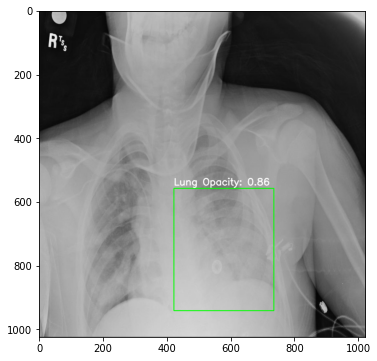

In [ ]:
#Model output
visualize_output('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/TestJPEGImages/01be392f-a46d-4aef-a57e-9cd1a80dd47e.jpeg', confidence_threshold=0.7)

In [ ]:
import pydicom as dcm
from PIL import Image
import traceback

In [ ]:
oroginal_data_df = pd.read_csv('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/All_Data.csv')
oroginal_data_df.fillna(0, inplace=True)

In [ ]:
def show_original_image(patientid):
  image_path = '/content/drive/MyDrive/AIML2021/Capstone/stage_2_train_images/' + patientid + '.dcm'
  
  try:
    ds = dcm.dcmread(image_path)
  except Exception:
    traceback.print_exc()
    return

  fig, a = plt.subplots(1,1)

  patient_records = oroginal_data_df[(oroginal_data_df['patientId'] == patientid)]
  print(patient_records)
  for index, patient_record in patient_records.iterrows():
    xmin, ymin, w, h = patient_record.x, patient_record.y, patient_record.width, patient_record.height
    print(xmin, ymin, w, h)
    rect = patches.Rectangle((xmin, ymin), w, h, linewidth = 1, edgecolor = 'r', facecolor = 'none')
    a.add_patch(rect)

  plt.imshow(ds.pixel_array)

    Unnamed: 0                             patientId      x      y  width  \
51          51  01be392f-a46d-4aef-a57e-9cd1a80dd47e  535.0  626.0  177.0   
52          52  01be392f-a46d-4aef-a57e-9cd1a80dd47e  175.0  825.0  168.0   

    height  Target         class  age gender view_position  center_x  center_y  
51   240.0       1  Lung Opacity   14      M            AP     623.5     746.0  
52   109.0       1  Lung Opacity   14      M            AP     259.0     879.5  
535.0 626.0 177.0 240.0
175.0 825.0 168.0 109.0


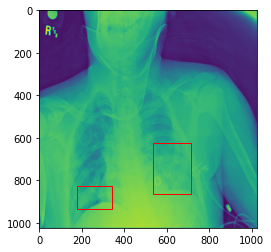

In [ ]:
show_original_image('01be392f-a46d-4aef-a57e-9cd1a80dd47e')

[0.8578036  0.65730727 0.6398243  0.40299782 0.3800182  0.3685947
 0.36843145 0.35739338 0.3511932  0.34420705 0.28462553 0.27002537
 0.26659605 0.26213562 0.2543513  0.25065452 0.24976692 0.24970844
 0.22793928 0.2087478  0.20806992 0.19977319 0.19439876 0.18080488
 0.18015546 0.17968756 0.17948925 0.17382473 0.1681422  0.1663431
 0.16572425 0.16505328 0.16225502 0.16071302 0.1605855  0.15833238
 0.15564793 0.15467012 0.15436861 0.14845115 0.14474592 0.1435146
 0.14108932 0.1407778  0.13986906 0.1361801  0.13315329 0.13230875
 0.13182154 0.12679952 0.12357521 0.11947855 0.11712039 0.11546516
 0.11524311 0.11314386 0.11015445 0.10971892 0.10721844 0.10712311
 0.10598493 0.10467243 0.10412803 0.10168529 0.10152355 0.10131907
 0.10042253 0.10021922 0.09980732 0.09965995 0.09826112 0.09705558
 0.09582606 0.09513107 0.09197214 0.09143785 0.08935273 0.08928263
 0.08816209 0.0873006  0.08708528 0.08689818 0.08683345 0.08651367
 0.0860247  0.0858441  0.08553997 0.08532116 0.0851419  0.0850186

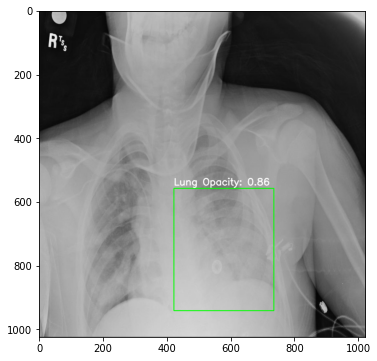

In [ ]:
visualize_output('/content/drive/MyDrive/AIML2021/Capstone/Object_Detection_API/TestJPEGImages/01be392f-a46d-4aef-a57e-9cd1a80dd47e.jpeg', confidence_threshold=0.7)

## CheXNet (Model 1):

ChexNet is a 121-layer convolutional neural network that inputs a chest X-ray image and outputs the probability of pneumonia along with a heatmap localizing the areas of the image most indicative of pneumonia.

*    They used dense connections and batch normalization to make the optimization of such a deep network tractable.

* The pneumonia detection task is a binary classification problem,
where the input is a frontal-view chest X-Ray image X and the
the output is a binary label y indicating ε(0, 1) the absence or
presence of pneumonia respectively.

* CheXNet is a 121-layer Dense Convolutional Network (DenseNet) trained on the ChestX-ray 14 dataset.

* DenseNets improve the flow of information and gradients through the network, making the optimization of very deep networks tractable. They replace the final fully-connected layer with one that has a single output, after which they applied a sigmoid nonlinearity.

* The weights of the network are initialized with weights from a model pre-trained on ImageNet. The network is trained end-to-end using Adam with standard parameters ( β 1 = 0.9 and β 2 = 0.999) . They trained the model using mini-batches of size 16. They used an initial learning rate of 0.001 that is decayed by a factor of 10 each time the validation loss plateaus after an epoch and picked the model with the lowest validation loss.

* They used the ChestX-ray14 dataset released by Wang et al. (2017) which  contains 112,120 frontal-view X-ray images of 30,805 unique patients.

* Annotated each image with up to 14 different thoracic pathology labels using automatic extraction methods on radiology reports. The label images that have pneumonia as one of the annotated pathologies as positive examples and label all other images as negative examples. For the pneumonia detection task, They randomly split the dataset into training (28744 patients, 98637 images), validation (1672 patients, 6351 images), and test (389 patients, 420 images). There is no patient overlap between the sets. Before inputting the images into the network, they downscale the images to 224x224 and normalize based on the mean and standard deviation of images in the ImageNet training set. They also augment the training data with random horizontal flipping.

* CheXNet localizes pathologies it identifies using Class Activation Maps, which highlight the areas of the X-ray that are most important for making a particular pathology classification. The captions for each image are provided by one of the practicings radiologists.





In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [ ]:
MODEL = os.path.join(DATA_DIR + 'model_weights/')

In [ ]:
# Read the training CSV File and remove duplicates on Patient Id
filepath = (DATA_DIR+'/stage_2_train_labels.csv')
Images_df = pd.read_csv(filepath)
Images_model_df = Images_df[['patientId','Target']]
Images_model_df=Images_model_df.drop_duplicates(subset='patientId')

In [ ]:
# Sample the training images for initial experimentation
Images_sample_df = Images_model_df.sample(frac=0.05,random_state=42)

In [ ]:
# Get the count
Images_sample_df['Target'].value_counts()

0    1051
1     283
Name: Target, dtype: int64

In [ ]:
def train_test_dict(Images_sample_df,test_size,random_state): 
   # Split into train and test validation datasets
    train_df, test_df = train_test_split(Images_sample_df, test_size=test_size, random_state=random_state, stratify=Images_sample_df[['Target']])
   # Convert to dictionary with patient-id as key and target as value
    train_dict=train_df.set_index('patientId')['Target'].to_dict()
    test_dict=test_df.set_index('patientId')['Target'].to_dict()

In [ ]:
import keras

# Define Custom Generator Class to be used in Model Generator
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, path,batch_size=128, dim=(224,224), n_channels=3,
                 n_classes=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path = path
        self.on_epoch_end()
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            dcm_file_sample = (self.path +"/"+ ID +".dcm")
            dcm_data_sample = dcm.filereader.dcmread(dcm_file_sample)
            image = dcm_data_sample.pixel_array
            image_array = np.stack([image] * 3, axis=2)
            image_array = image_array / 255.
            image_array = resize(image_array, (224, 224), mode= 'constant', anti_aliasing=True)
            X[i,] = image_array

            # Store class
            y[i] = self.labels[ID]

        return X,y

In [ ]:
from keras.models import load_model

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
#from keras.optimizers import Adam

# Define the DenseNet model pre-loaded with imagenet weights with last layer set as false
input_shape = (224, 224, 3)
num_of_class=1
img_in = Input(input_shape)              
model = DenseNet121(include_top= False , 
                weights=MODEL+'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',    
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg') 

# The pre-trained model has classification output for 14 categories and hence Dense layer is defined with layer 14
x = model.output  
predictions = Dense(14, activation="sigmoid", name="predictions")(x)    
model = Model(inputs=img_in, outputs=predictions)

In [ ]:
# Load pre-trained weights on similar dataset
model.load_weights(MODEL+"brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

In [ ]:
# Remove the last dense layer of 14 classes and print the summary
model.layers.pop()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
# Add a new dense layer of 1 class and chain the previous layer output to new model
new_layer = Dense(1, activation="sigmoid", name="my_predictions")    
inp = model.input
out = new_layer(model.layers[-1].output)
model2 = Model(inp, out)

In [ ]:
#Print new model summary
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
train_df, test_df = train_test_split(Images_sample_df, test_size=0.2, random_state=42, stratify=Images_sample_df[['Target']])
train_dict=train_df.set_index('patientId')['Target'].to_dict()
test_dict=test_df.set_index('patientId')['Target'].to_dict()

In [ ]:
# Create Train and Test generator
train_generator = DataGenerator(list(train_dict.keys()), train_dict,path=TRAIN_IMAGES,batch_size=32)
validation_generator = DataGenerator(list(test_dict.keys()), test_dict,path=TRAIN_IMAGES,batch_size=1)

In [ ]:
#Define Custom Metrics Functions to be used in Keras Training
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

#Set Early stopping parameter and Reduce Learning rate on Plateau
callbacks_list = [EarlyStopping(monitor='val_loss',patience=5,),
                  ModelCheckpoint(filepath=MODEL+'CheXnet.h5',monitor='val_loss',save_best_only=True,),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,)]

In [ ]:
# Set only the last layer as Trainable
def model_train_layers(model,layer):
    model2.trainable = True
    set_trainable = False
    for layer in model2.layers:
      #print(layer.name)
        if layer.name == layer:
            set_trainable = True
        if set_trainable:
             layer.trainable = True
        else:
             layer.trainable = False

In [ ]:
model_train_layers(model2,"my_predictions")

In [ ]:
# Compile with binary cross entropy loss
optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
from skimage.transform import resize

# Run Fit Generator
history=model2.fit_generator(generator=train_generator,
                    epochs=7,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

Epoch 1/7
33/33 [==============================] - 554s 17s/step - loss: 0.6933 - acc: 0.2093 - f1_m: 0.3415 - precision_m: 0.2093 - recall_m: 1.0000 - val_loss: 0.6934 - val_acc: 0.2135 - val_f1_m: 0.2135 - val_precision_m: 0.2135 - val_recall_m: 0.2135 - lr: 0.0010
Epoch 2/7
33/33 [==============================] - 218s 7s/step - loss: 0.6933 - acc: 0.2121 - f1_m: 0.3449 - precision_m: 0.2121 - recall_m: 1.0000 - val_loss: 0.6934 - val_acc: 0.2135 - val_f1_m: 0.2135 - val_precision_m: 0.2135 - val_recall_m: 0.2135 - lr: 0.0010
Epoch 3/7
33/33 [==============================] - 214s 7s/step - loss: 0.6933 - acc: 0.2121 - f1_m: 0.3413 - precision_m: 0.2121 - recall_m: 1.0000 - val_loss: 0.6934 - val_acc: 0.2135 - val_f1_m: 0.2135 - val_precision_m: 0.2135 - val_recall_m: 0.2135 - lr: 0.0010
Epoch 4/7
33/33 [==============================] - 219s 7s/step - loss: 0.6933 - acc: 0.2112 - f1_m: 0.3425 - precision_m: 0.2112 - recall_m: 1.0000 - val_loss: 0.6934 - val_acc: 0.2135 - val_f1_m: 

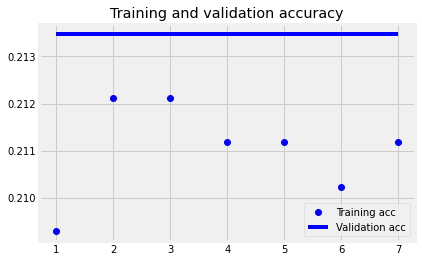

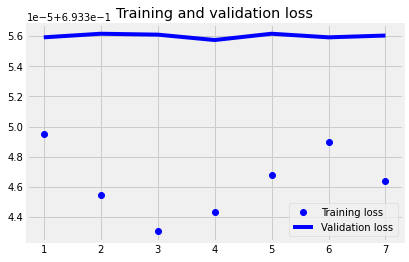

In [ ]:
# Plot the results on Loss and Accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Given the very small sample size used for training, the loss is high and the accuracy is low. 

The other reason is that the sample used for training was imbalanced, leading to poor recall. 

## CheXnet (Model 2):

### Load Nodule Locations

In [ ]:
# empty dictionary
nodule_locations = {}
# load table
with open(os.path.join('stage_2_train_labels.csv/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        nodule = rows[5]
        # if row contains a nodule add label to dictionary
        # which contains a list of nodule locations per filename
        if nodule == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save nodule location in dictionary
            if filename in nodule_locations:
                nodule_locations[filename].append(location)
            else:
                nodule_locations[filename] = [location]

### Load Filenames

In [ ]:
# load and shuffle filenames
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 500
train_filenames = filenames[300:900]
valid_filenames = filenames[:200]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 600
n valid samples 200


### Exploration

Total train images: 26684
Images with nodule: 6012


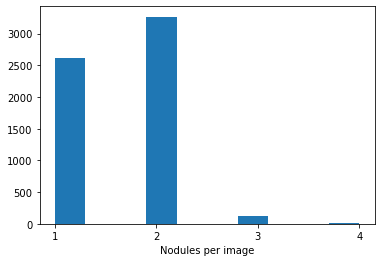

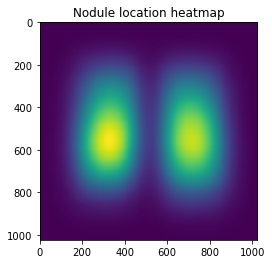

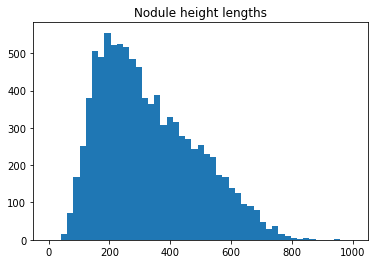

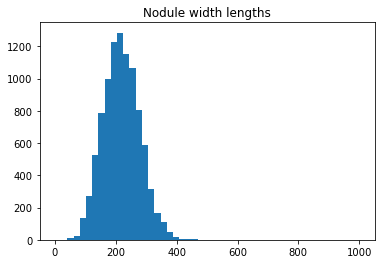

Minimum nodule height: 45
Minimum nodule width:  40


In [ ]:
print('Total train images:',len(filenames))
print('Images with nodule:', len(nodule_locations))

ns = [len(value) for value in nodule_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Nodules per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in nodule_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Nodule location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Nodule height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Nodule width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum nodule height:', np.min(hs))
print('Minimum nodule width: ', np.min(ws))

[195.79966942 228.04446281]
[257.60513552 503.99514979]


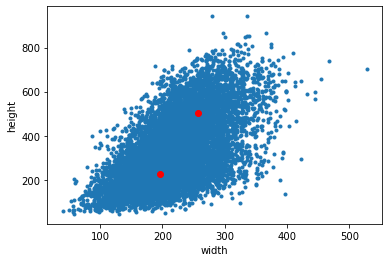

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(np.array([ws, hs]).T)
centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(ws, hs, marker='.')
plt.xlabel('width')
plt.ylabel('height')
for center in centers:
    print(center)
    plt.scatter(center[0], center[1], c='red')
plt.show()

### Data Generator

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=200, image_size=512, shuffle=True, predict=False, augment = False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in nodule_locations:
            # loop through nodules
            for location in nodule_locations[filename]:
                # add 1's at the location of the nodule
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

### Network

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=5):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### Train Network

In [ ]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer=keras.optimizers.Adam(lr=.01),loss=keras.losses.binary_crossentropy,metrics=['accuracy', mean_iou])

# create train and validation generators
folder = 'stage_2_train_images'
train_gen = generator(folder, train_filenames, nodule_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, nodule_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=2, shuffle=True, verbose=1)

C:\Users\priya\AppData\Local\Temp/ipykernel_2508/4233347839.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=2, shuffle=True, verbose=1)


Epoch 1/2
18/18 [==============================] - 518s 28s/step - loss: 0.2242 - accuracy: 0.9529 - mean_iou: 0.6472 - val_loss: 0.3733 - val_accuracy: 0.9758 - val_mean_iou: 0.7657
Epoch 2/2
18/18 [==============================] - 493s 27s/step - loss: 0.1130 - accuracy: 0.9747 - mean_iou: 0.7726 - val_loss: 0.3733 - val_accuracy: 0.9758 - val_mean_iou: 0.7657


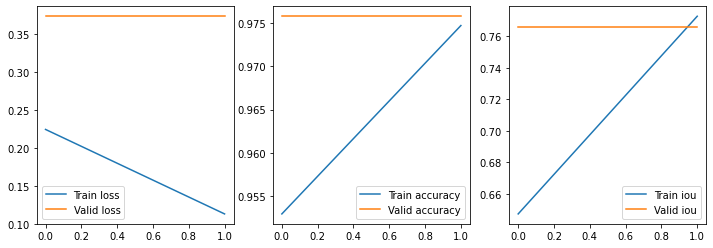

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

### Predict Images

In [ ]:
# load and shuffle filenames
folder = 'stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

n test samples: 3000
1/1 [==============================] - 4s 4s/step


In [ ]:
preds

array([[[[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00]],

        ...,

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [6.1882649e-30],
         [6.1882649e-30],
         [6.1882649e-30]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [6.1882649e-30],
         [6.1882649e-30],
         [6.1882649e-30]],

        [[0.0000000e+00],
         [0.0000000e+00],
         [0.0000000e+00],
         ...,
         [6.1882649e-30],
        

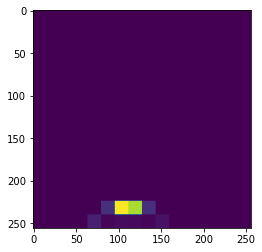

In [ ]:
plt.imshow(preds[19])